# COMPONENT 1 - WEB SCRAPING MODULE

### IMPORTING THE LIBRARIES

In [4]:
from bs4 import BeautifulSoup
import requests
import json
import pandas as pd
import numpy as np
import re
import os

In [5]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=RuntimeWarning)

## EXTRACTING NEWS DATA FOR TWO WEEKS (Feb 1, 2021 to Feb 14, 2021)

### LIST OF URLS OF 14 DAYS:

The urls of the web pages are as follows:

https://www.thehindu.com/archive/web/2021/02/01/

https://www.thehindu.com/archive/web/2021/02/02/ 

................

https://www.thehindu.com/archive/web/2021/02/14/

Since the urls follow a similar pattern, we can create the list of all the urls as follows:

In [ ]:
num_list = [ "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14"]

In [ ]:
webpage_links = []
for i in range(len(num_list)):
  link = "https://www.thehindu.com/archive/web/2021/02/{0}/".format(num_list[i])
  webpage_links.append(link)

In [ ]:
webpage_links

### CREATING A LIST OF ALL THE URLS FROM THE WEBPAGES OF 14 DAYS:
### FROM FEB 1, 2021 TO FEB 14, 2021


In [ ]:
URL_list = []
for link in webpage_links:
  page = requests.get(link)
  soup = BeautifulSoup(page.content, "html.parser")
  for item in soup.find_all(attrs={'class':'archive-list'}):
    for link in item.find_all(href=True):
        href=link.get('href')
        URL_list.append(href)

In [ ]:
len(URL_list)

### CREATING A LIST OF JSON FILES

In [ ]:
json_files = []
for i in range(len(URL_list)):
  json_files.append('thehindu_feb_02_file_{0}.json'.format(i))

### EXTRACTING THE USEFUL CONTENT FROM THE URLs:

In [ ]:
for i in range(len(URL_list)):
  news_data = {"text" : []}
  page = requests.get(URL_list[i])
  soup = BeautifulSoup(page.content, "html.parser")

#SCRAPING THE TITLE OF THE WEBPAGE
  title = soup.find('h1')
  if title!= None:
    news_data["text"].append(title.text)

#SCRAPING THE SUB TITLE OF THE WEBPAGE
  sub_title = soup.find_all('h2')
  if sub_title != None:
    for st in sub_title:
      news_data["text"].append(st.text)

      
#SCRAPING CONTENT FROM PARAGRAPH TAGS WITH A SPECIFIC ID
  regex = re.compile('.*content-body-.*')
  for item in soup.find_all("div", {'id': regex}):
    for p in item.find_all('p'):
      news_data["text"].append(p.text)  

#STORING THE CONTENT FROM EACH WEBPAGE IN A SEPARATE JSON FILE
  with open(json_files[i], 'w') as jsonfile:
    json.dump(news_data, jsonfile)

#SAVING THE JSON FILES IN GOOGLE DRIVE
  !cp {json_files[i]} /content/drive/MyDrive/JSON_FILES2


### STORING THE TEXT FROM EACH FILE IN A LIST

In [ ]:
raw_text = []
for js in json_files:
   with open(js) as json_file:
        json_text = json.load(json_file)
        raw_text.append(json_text['text'])

### SAVING THE RAW TEXT IN A SEPARATE .JSON FILE

In [ ]:
#To save the data from Feb 1 to Feb 7
with open('raw_text_01.json', 'w') as jsonfile:
   json.dump(raw_text, jsonfile)
!cp raw_text_01.json /content/drive/MyDrive/RAW_TEXT

In [ ]:
#To save the data from Feb 8 to Feb 14
with open('raw_text_02.json', 'w') as jsonfile:
    json.dump(raw_text, jsonfile)
!cp raw_text_02.json /content/drive/MyDrive/RAW_TEXT

## CREATING A DATAFRAME TO STORE THE FILE NAMES AND THE CORRESPONDING URLs

In [ ]:
tab_head = ["File_Scraped", "Corresponding URL"]
df_data = pd.DataFrame(zip(json_files, URL_list), columns = tab_head)
df_data[:10]

### STORING THE DATAFRAME IN .CSV FILE

In [ ]:
df_data.to_csv('URLs_to_file_mapping.csv', sep ='|')
!cp URLs_to_file_mapping.csv /content/drive/MyDrive/CSV_FILES

### DISPLAYING THE CONTENT IN .CSV FILE

In [ ]:
new_df = pd.read_csv('URLs_to_file_mapping.csv')
new_df.head(10)

In [ ]:
new_df.shape

### VIEWING THE RAW DATA

In [ ]:
raw_text = []
f1 = open("/content/drive/MyDrive/RAW_TEXT/raw_text_01.json")
data1 = json.load(f1)
for i in data1:
  raw_text.append(i) 

f2 = open("/content/drive/MyDrive/RAW_TEXT/raw_text_02.json")
data2 = json.load(f2)
for i in data2:
  raw_text.append(i)

In [ ]:
len(raw_text)

5565

## OUTLIERS DETECTION AND REMOVAL

CALCULATING THE LENGTH OF ALL THE FILES

In [ ]:
length = []
for files in raw_text:
  c = len(str(files).split())
  length.append(c)

VISUALISING USING BOX PLOT

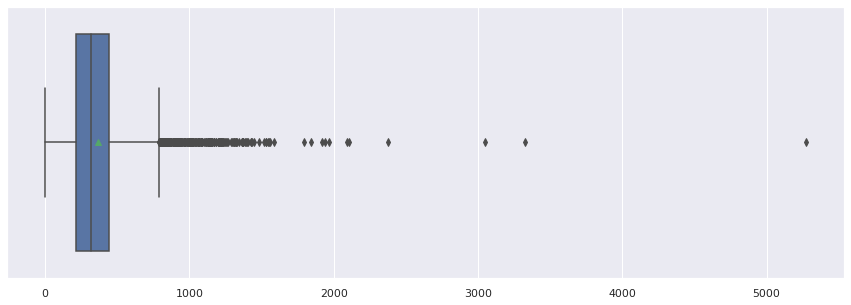

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,5)})
sns.boxplot(length, width = 0.8, showmeans = True)

DETECTING THE OUTLIERS

In [ ]:
def detect_outlier(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [5, 95])
 
    # compute IRQ
    iqr = q3 - q1
 
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
 
    outliers = [x for x in data if x <= lower_bound or x >= upper_bound]
    print("Lower Bound: ", lower_bound)
    print("Upper Bound: ",upper_bound)
    return outliers
 
# input data
detect_outlier((length))

Lower Bound:  -897.2000000000003
Upper Bound:  1786.0000000000005


[5274, 2093, 2374, 3324, 1793, 2109, 1845, 1943, 1922, 3047, 1965]

OUTLIERS REMOVAL

In [ ]:
#Removing the text having length greater than 1786 words
modified_text = []
for text in raw_text:
  c = len(str(text).split())
  if c <= 1786:
    modified_text.append(text)
len(modified_text)

5554

BOX PLOT

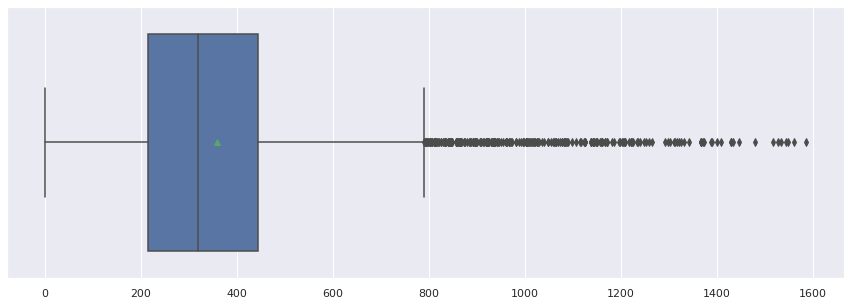

In [ ]:
length = [i for i in length if i < 1786]
sns.set(rc={'figure.figsize':(15,5)})
sns.boxplot(length, width = 0.8, showmeans=True)

The length of most documents lies between 200-450 words.
The mean of length of all the documents is around 350 words.

# Component 2 - Topic Model

## DATA PREPROCESSING

In [16]:
#FOR STOP WORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#FOR LEMMATIZATION
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#FOR STEMMING
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

#FOR BIGRAMS
from nltk.util import bigrams
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### PERFORMING THE TEXT PREPROCESSING

In [ ]:
def data_preprocessing(raw_text):
  filtered_text = []     #TO STORE THE PROCESSED DATA    
  for t in raw_text:
    filtered_sentence = ""
    stemmed_list = []
    lemmatized_list = []
    
    sentence = str(t)
    # Remove new line characters
    for word in sentence:
      word = word.strip()

    #Data Cleansing
    sentence = re.sub(r'[^\w\s]', ' ', sentence)


    #Removing numbers
    sentence = re.sub(r'[0-9]', '', sentence)
    
    #Tokenization
    words = nltk.word_tokenize(sentence)

    #Lowercase
    for word in words:
      word.lower()
    
    #Stop words removal
    words = [w for w in words if not w in stop_words]
    
    #Stemming
    for word in words:
        stemmed_word = stemmer.stem(word)
        stemmed_list.append(stemmed_word)
        
    #Lemmatization
    for s_word in stemmed_list:
        lemmatized_word = lemmatizer.lemmatize(s_word)
        lemmatized_list.append(lemmatized_word)

    
    lemmatized_list = [i for i in lemmatized_list if len(i) > 3]
    
    filtered_text.append(lemmatized_list)
  return filtered_text

In [ ]:
filtered_text = data_preprocessing(modified_text)

### FREQUENCY DISTRIBUTION PLOT

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist

In [ ]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

In [ ]:
words_list = []
for line in filtered_text:
  for word in line:
    words_list.append(word)

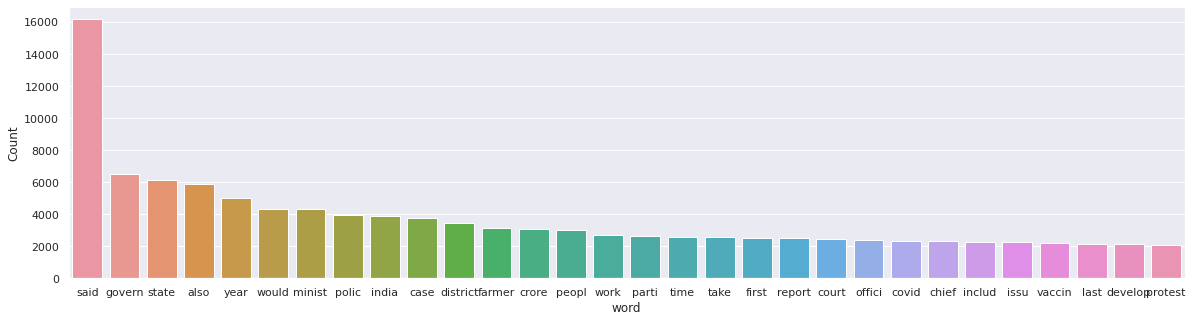

In [ ]:
freq_words(words_list)

From the distribution plot, it is observed that there are some irrelevant words present in high frequency in the text. Hence, to improve our model, we can remove these words.

Extending the stop words list:

In [ ]:
extra_stopwords = ['crore', 'first', 'said', 'work', 'also', 'case', 'would', 'take', 'time', 'last', 'year', 'three', 'make', 'nthe', 'need', 'even',
                   'issu', 'well', 'come', 'made', 'come', 'howev', 'work', 'februari', 'includ','like']
stop_words.extend(extra_stopwords)

In [ ]:
words_list = [w for w in words_list if not w in stop_words]

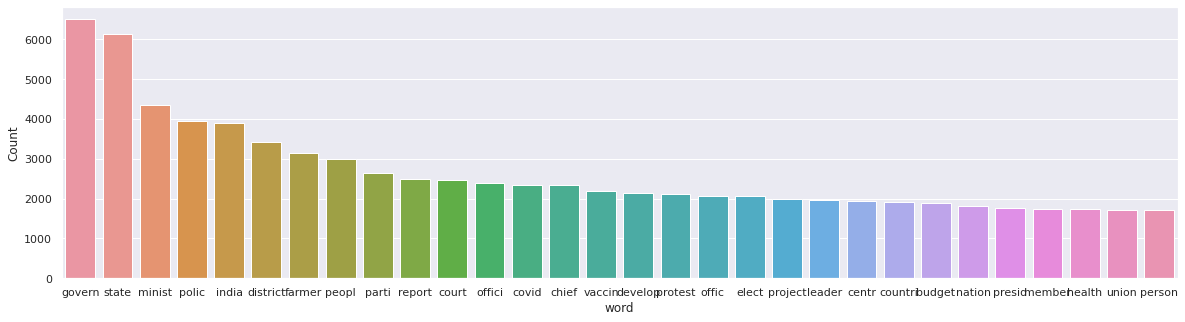

In [ ]:
freq_words(words_list)

In [ ]:
filtered_text2 = []
for sentence in filtered_text:
  sentence = [w for w in sentence if not w in extra_stopwords]
  filtered_text2.append(sentence)

In [ ]:
len(filtered_text2)

5554

### WORD CLOUD

In [ ]:
words_string = " ".join(words_list)

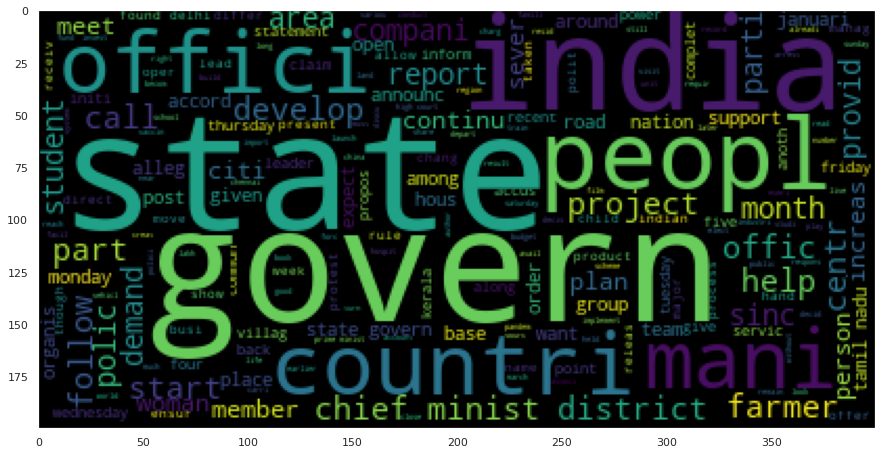

In [ ]:
import wordcloud

wordcloud = wordcloud.WordCloud()
wordcloud.generate(words_string)
plt.figure( figsize=(15,10) )
plt.rcParams["axes.grid"] = False
plt.imshow(wordcloud)

### BIGRAMS AND TRIGRAMS FORMATION

In [ ]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 25 times or more).
bigram = Phrases(filtered_text2, min_count=25)
for idx in range(len(filtered_text2)):
    for token in bigram[filtered_text2[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            if token not in filtered_text2[idx]:
              filtered_text2[idx].append(token)

### FREQUENCY DISTRIBUTION OF BIGRAMS:

In [ ]:
import nltk
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

word_fd = nltk.FreqDist(words_list)
bigram_fd = nltk.FreqDist(nltk.bigrams(words_list))

bigram_fd.most_common()[:25]

[(('chief', 'minist'), 1288),
 (('state', 'govern'), 841),
 (('tamil', 'nadu'), 786),
 (('high', 'court'), 613),
 (('prime', 'minist'), 599),
 (('social', 'medium'), 445),
 (('suprem', 'court'), 394),
 (('financ', 'minist'), 379),
 (('covid', 'vaccin'), 349),
 (('farmer', 'protest'), 342),
 (('union', 'budget'), 321),
 (('rajya', 'sabha'), 314),
 (('test', 'posit'), 292),
 (('polic', 'station'), 283),
 (('uttar', 'pradesh'), 280),
 (('andhra', 'pradesh'), 276),
 (('narendra', 'modi'), 267),
 (('covid', 'pandem'), 251),
 (('central', 'govern'), 245),
 (('west', 'bengal'), 230),
 (('told', 'hindu'), 228),
 (('minist', 'narendra'), 227),
 (('frontlin', 'worker'), 227),
 (('gener', 'secretari'), 222),
 (('medic', 'colleg'), 217)]

### FREQUENCY DISTRIBUTION OF TRIGRAMS:

In [ ]:
trigrams=ngrams(words_list,3)
trigram_fd = nltk.FreqDist(trigrams)
trigram_fd.most_common()[:20]

[(('minist', 'narendra', 'modi'), 209),
 (('prime', 'minist', 'narendra'), 207),
 (('financ', 'minist', 'nirmala'), 170),
 (('minist', 'nirmala', 'sitharaman'), 169),
 (('bharatiya', 'janata', 'parti'), 121),
 (('former', 'chief', 'minist'), 117),
 (('jagan', 'mohan', 'reddi'), 113),
 (('chief', 'minist', 'edappadi'), 108),
 (('minist', 'edappadi', 'palaniswami'), 108),
 (('subscrib', 'today', 'cach'), 105),
 (('today', 'cach', 'newslett'), 105),
 (('cach', 'newslett', 'quick'), 105),
 (('newslett', 'quick', 'snapshot'), 105),
 (('quick', 'snapshot', 'tech'), 105),
 (('snapshot', 'tech', 'stori'), 105),
 (('tech', 'stori', 'click'), 105),
 (('stori', 'click', 'subscrib'), 102),
 (('click', 'subscrib', 'free'), 102),
 (('medic', 'colleg', 'hospit'), 91),
 (('madra', 'high', 'court'), 85)]

In [ ]:
filtered_text2

In [ ]:
#To save the data from Feb 1 to Feb 7
with open('filtered_text.json', 'w') as jsonfile:
   json.dump(filtered_text2, jsonfile)
!cp filtered_text.json /content/drive/MyDrive/RAW_TEXT

## SPLITTING THE DATA INTO TRAINING SET AND TEST SET

In [7]:
filtered_text = []
f1 = open("/content/drive/MyDrive/RAW_TEXT/filtered_text.json")
data1 = json.load(f1)
for i in data1:
  filtered_text.append(i)

In [ ]:
import csv
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/CSV_FILES/URLs_to_file_mapping.csv", header = None, delimiter = "|" )
data_d = data[1:]

In [ ]:
df = pd.DataFrame(zip(filtered_text))
df_data = pd.merge(data_d,df, right_index=True, left_index=True)

In [ ]:
df_data

,0_x,1,2,0_y
1,0.0,thehindu_feb_02_file_0.json,https://www.thehindu.com/sport/other-sports/va...,"[nadvantag, india, nanindya, book, draw, prais..."
2,1.0,thehindu_feb_02_file_1.json,https://www.thehindu.com/sport/tennis/advantag...,"[nmurray, river, open, nagal, lose, season, op..."
3,2.0,thehindu_feb_02_file_2.json,https://www.thehindu.com/sport/tennis/murray-r...,"[nchip, sale, rose, global, rush, nwhile, base..."
4,3.0,thehindu_feb_02_file_3.json,https://www.thehindu.com/sci-tech/technology/c...,"[nelon, musk, bitcoin, verg, wide, accept, nmu..."
5,4.0,thehindu_feb_02_file_4.json,https://www.thehindu.com/sci-tech/technology/e...,"[nstudi, cigarett, pattern, sensor, call, leve..."
...,...,...,...,...
5549,5548.0,thehindu_feb_02_file_5548.json,https://www.thehindu.com/news/cities/Madurai/c...,"[nfinanc, ministri, infus, gener, insur, compa..."
5550,5549.0,thehindu_feb_02_file_5549.json,https://www.thehindu.com/news/cities/Madurai/c...,"[nnirmala, sitharaman, address, post, budget, ..."
5551,5550.0,thehindu_feb_02_file_5550.json,https://www.thehindu.com/news/cities/Madurai/1...,"[nstock, ammunit, fight, crab, nnormal, hospit..."
5552,5551.0,thehindu_feb_02_file_5551.json,https://www.thehindu.com/news/cities/Madurai/m...,"[ncover, drive, pandem, ncovid, propel, choos,..."


In [ ]:
len(filtered_text)

5554

In [8]:
from sklearn.model_selection import train_test_split
training_set, test_set  = train_test_split(filtered_text, test_size=0.1, random_state = 0)

In [ ]:
from sklearn.model_selection import train_test_split
training_set, test_set  = train_test_split(df_data, test_size=0.1, random_state = 0)

Getting the file names for the test set elements to map back to the corresponding URLs.

In [ ]:
test_set.head(30)

,0_x,1,2,0_y
1961,1960.0,thehindu_feb_02_file_1960.json,https://www.thehindu.com/news/national/other-s...,"[ntrust, dhannipur, mosqu, project, land, disp..."
2637,2636.0,thehindu_feb_02_file_2636.json,https://www.thehindu.com/news/cities/Tiruchira...,"[ndoctor, rural, replant, sever, finger, team,..."
248,247.0,thehindu_feb_02_file_247.json,https://www.thehindu.com/news/national/telanga...,"[nstate, record, fresh, covid, sunday, telanga..."
4797,4796.0,thehindu_feb_02_file_4796.json,https://www.thehindu.com/news/national/other-s...,"[nind, second, test, both, team, happi, back, ..."
1035,1034.0,thehindu_feb_02_file_1034.json,https://www.thehindu.com/news/national/karnata...,"[nmysurean, propos, innov, handsom, prize, nth..."
1787,1786.0,thehindu_feb_02_file_1786.json,https://www.thehindu.com/society/beyond-the-bo...,"[nchola, financi, post, increas, profit, ntota..."
2027,2026.0,thehindu_feb_02_file_2026.json,https://www.thehindu.com/news/cities/Delhi/ple...,"[nvictimis, desir, throughout, bhagavad, gita,..."
4427,4426.0,thehindu_feb_02_file_4426.json,https://www.thehindu.com/news/cities/Kochi/isl...,"[direct, provid, basic, amen, island, divis, b..."
5196,5195.0,thehindu_feb_02_file_5195.json,https://www.thehindu.com/news/cities/Kochi/boo...,"[nnew, registrar, calicut, univers, appoint, n..."
16,15.0,thehindu_feb_02_file_15.json,https://www.thehindu.com/news/morning-digest-f...,"[nnew, analysi, with, myanmar, militari, coup,..."


In [ ]:
len(test_set)

556

# TOPIC MODELING

## LDA MODEL

In [9]:
#IMPORTING THE LIBRARIES
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [10]:
id2word = corpora.Dictionary(training_set)

#Removing very rare words
id2word.filter_extremes(no_below=20, no_above=0.5)

# Create Corpus
texts = training_set

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

### TERM FREQUENCY

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

## BUILDING THE LDA TOPIC MODEL

 ## Coherence Scores obtained during parameter tuning

<table>
<tr>
<th>num_topics</th><th>random_state</th>
<th>iterations</th><th>passes</th>
<th>alpha</th><th>chunksize</th>
<th>Coherence Score</th><th>Perplexity</th>
</tr>
<tr>
<td>25</td><td>42</td><td>50</td><td>20</td><td>auto</td><td>1000</td><td>0.566</td><td>-7.166</td>
</tr>
<td>20</td><td>42</td><td>100</td><td>150</td><td>auto</td><td>1000</td><td>0.587</td><td>-7.206</td>
</tr>
<tr>
<td>15</td><td>42</td><td>50</td><td>100</td><td>auto</td><td>1000</td><td>0.595</td><td>-7.202</td>
</tr>
<tr>
<td>15</td><td>42</td><td>50</td><td>120</td><td>auto</td><td>1000</td><td>0.595</td><td>-7.202</td>
</tr>
<tr>
<td>15</td><td>342</td><td>50</td><td>120</td><td>auto</td><td>1000</td><td>0.597</td><td>-7.222</td>
</tr>
<tr>
<td>14</td><td>563</td><td>50</td><td>120</td><td>auto</td><td>1000</td><td>0.590</td><td>-7.226</td>
</tr>

<tr>
<td>14</td><td>342</td><td>50</td><td>120</td><td>auto</td><td>1000</td><td>0.610</td><td>-7.225</td>
</tr>







### Computing Model Perplexity and Coherence Score

NUM TOPICS = 14

In [11]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state= 342,
                                           iterations = 50,
                                           chunksize=1000,
                                           passes=120,
                                           alpha='auto',
                                           per_word_topics=True)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=training_set, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.225670495648191

Coherence Score:  0.6105100190899231


### Saving the model

In [ ]:
from sklearn.externals import joblib
 
# Save the model as a pickle in a file
joblib.dump(lda_model, '/content/drive/MyDrive/Models/final_model.pkl')

['/content/drive/MyDrive/Models/final_model.pkl']

## LDA MALLET

In [ ]:
import os
def install_java_jdk():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version

install_java_jdk

<function __main__.install_java_jdk>

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive

Mounted at /content/gdrive
/content/gdrive


In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

### COMPUTING COHERENCE VALUE FOR LDA MALLET

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=training_set, start=5, limit=80, step=5)

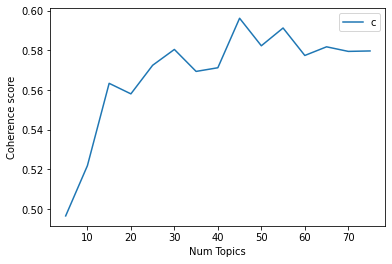

In [ ]:
# Show graph
import matplotlib.pyplot as plt
limit=80; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))

Num Topics = 5  has Coherence Value of 0.497
Num Topics = 10  has Coherence Value of 0.522
Num Topics = 15  has Coherence Value of 0.563
Num Topics = 20  has Coherence Value of 0.558
Num Topics = 25  has Coherence Value of 0.572
Num Topics = 30  has Coherence Value of 0.58
Num Topics = 35  has Coherence Value of 0.569
Num Topics = 40  has Coherence Value of 0.571
Num Topics = 45  has Coherence Value of 0.596
Num Topics = 50  has Coherence Value of 0.582
Num Topics = 55  has Coherence Value of 0.591
Num Topics = 60  has Coherence Value of 0.577
Num Topics = 65  has Coherence Value of 0.582
Num Topics = 70  has Coherence Value of 0.579
Num Topics = 75  has Coherence Value of 0.58


Out of all the models, LDA Model with number of topics = 14 has the best performance with Coherence Score: 0.610 . Thus, we proceed furthur with the same model.

## VIEWING THE TOPICS IN LDA MODEL

In [ ]:
# Print the Keyword in the topics
from pprint import pprint
pprint(lda_model.print_topics(num_words=15))
doc_lda = lda_model[corpus]

[(0,
  '0.041*"vaccin" + 0.031*"covid" + 0.024*"health" + 0.019*"district" + '
  '0.019*"report" + 0.017*"worker" + 0.016*"death" + 0.016*"test" + '
  '0.016*"hospit" + 0.013*"total" + 0.012*"state" + 0.012*"medic" + '
  '0.011*"number" + 0.010*"patient" + 0.009*"posit"'),
 (1,
  '0.056*"farmer" + 0.036*"protest" + 0.020*"govern" + 0.015*"farm" + '
  '0.014*"delhi" + 0.009*"peopl" + 0.009*"singh" + 0.008*"border" + '
  '0.008*"union" + 0.008*"agit" + 0.008*"leader" + 0.007*"demand" + '
  '0.007*"support" + 0.007*"minist" + 0.006*"agricultur"'),
 (2,
  '0.014*"test" + 0.011*"india" + 0.011*"team" + 0.010*"game" + 0.009*"play" + '
  '0.009*"second" + 0.008*"open" + 0.008*"star" + 0.008*"england" + '
  '0.007*"player" + 0.007*"match" + 0.007*"seri" + 0.006*"uttarakhand" + '
  '0.006*"back" + 0.006*"singh"'),
 (3,
  '0.038*"district" + 0.030*"elect" + 0.026*"polic" + 0.020*"panchayat" + '
  '0.018*"poll" + 0.018*"offic" + 0.017*"villag" + 0.011*"offici" + '
  '0.010*"collector" + 0.008*"co

## Naming the topics with IAB Taxonomy.

In [12]:
Topics = ["0.	Medical Health",
"1.	Political Issues",
"2.	Sports – Cricket",
'3.	News and Politics – Elections',
'4.	New and Politics – Law',
'5.	News and Politics – National News',
'6.	Business and Finance',
'7.	Region/State',
'8.	Technology and Computing',
'9.	Education',
'10.	Region/State',
'11.	Movies',
'12.	International News',
'13.	National News - Projects'
]

In [13]:
table_head = ['Topic', 'Keywords']

In [15]:
df = pd.DataFrame(zip(Topics, lda_model.print_topics()), columns= table_head)
df

,Topic,Keywords
0,0.\tMedical Health,"(0, 0.041*""vaccin"" + 0.031*""covid"" + 0.024*""he..."
1,1.\tPolitical Issues,"(1, 0.056*""farmer"" + 0.036*""protest"" + 0.020*""..."
2,2.\tSports – Cricket,"(2, 0.014*""test"" + 0.011*""india"" + 0.011*""team..."
3,3.\tNews and Politics – Elections,"(3, 0.038*""district"" + 0.030*""elect"" + 0.026*""..."
4,4.\tNew and Politics – Law,"(4, 0.035*""polic"" + 0.031*""court"" + 0.013*""arr..."
5,5.\tNews and Politics – National News,"(5, 0.045*""parti"" + 0.026*""leader"" + 0.023*""co..."
6,6.\tBusiness and Finance,"(6, 0.025*""budget"" + 0.013*""bank"" + 0.012*""gov..."
7,7.\tRegion/State,"(7, 0.039*""govern"" + 0.031*""state"" + 0.017*""mi..."
8,8.\tTechnology and Computing,"(8, 0.021*""compani"" + 0.013*""market"" + 0.010*""..."
9,9.\tEducation,"(9, 0.025*""student"" + 0.019*""school"" + 0.013*""..."


### VISUALISE TOPICS

In [42]:
pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 4.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.5 MB 177 kB/s 
     |████████████████████████████████| 15.7 MB 76 kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=69b216e7f99570febe66b27731b43e00e5f3f8e505192dee33ae8b9f49c77d59
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into 

In [ ]:
# Visualize the topics
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

## Word Clouds of Top N Keywords in Each Topic

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=30,
                  colormap='tab10',
                  contour_color='steelblue',
                  color_func=lambda *args, **kwargs: cols[i])

topics = lda_model.print_topics()

fig, axes = plt.subplots(2 ,2 , figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=20, hspace=20)
plt.axis('off')
plt.margins(x=10, y=10)
plt.tight_layout()
plt.show()

## TESTING THE MODEL ON TEST SET

### TOPIC DISTRIBUTION FOR TEST SET

In [ ]:
Topic_distribution= []
for i in range(30):
  print(lda_model[id2word.doc2bow(test_set[i])][0])
  Topic_distribution.append(lda_model[id2word.doc2bow(test_set[i])][0])

[(2, 0.03881855), (3, 0.021523407), (4, 0.38004357), (7, 0.05425667), (9, 0.054038815), (10, 0.13542572), (11, 0.015396904), (12, 0.053333037), (13, 0.24535295)]
[(2, 0.037951425), (3, 0.04951125), (7, 0.053341895), (10, 0.25071847), (11, 0.4220597), (12, 0.16435793), (13, 0.018877313)]
[(0, 0.29327112), (3, 0.09951886), (4, 0.02828681), (7, 0.046056423), (9, 0.5239373)]
[(2, 0.722297), (11, 0.24666493)]
[(3, 0.04351358), (4, 0.12107847), (6, 0.0861495), (7, 0.42893568), (10, 0.034872994), (11, 0.2812925)]
[(0, 0.06300349), (4, 0.06642057), (7, 0.09784276), (9, 0.0439657), (10, 0.010232563), (12, 0.14984736), (13, 0.56595707)]
[(4, 0.33372495), (5, 0.011378192), (7, 0.26724777), (10, 0.050284732), (12, 0.07099035), (13, 0.26268983)]
[(3, 0.8366962), (4, 0.046903517), (10, 0.06108053), (11, 0.021735055), (13, 0.020973038)]
[(0, 0.9849161)]
[(0, 0.12205135), (1, 0.30727822), (2, 0.014836981), (3, 0.052589457), (4, 0.07721465), (6, 0.04421107), (7, 0.039981566), (10, 0.102471314), (11, 0.

### Calculating the Coherence Score on Test Set

In [40]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=test_set, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5089754916802771
